### **Import Necessary Libraries**

In [31]:
!pip install transformers -q

In [32]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import cv2
from datasets import load_metric
import torch

### **Dataset Manipulation**

In [33]:
# Set the path to the dataset
dataset_path = '/kaggle/input/cassava-leaf-disease-classification/data'

# List all the subdirectories (class folders) in the dataset
class_folders = os.listdir(dataset_path)

# Initialize an empty DataFrame to store the data
df = pd.DataFrame(columns=['image_path', 'label'])

# Loop through each class folder
for class_folder in class_folders:
    class_path = os.path.join(dataset_path, class_folder)

    # List all the images in the class folder, limited to the first 1000
    images = os.listdir(class_path)[:1000]

    # Add each full image path and its corresponding label to the DataFrame
    data = [{'image_path': os.path.join(class_path, image), 'label': class_folder.split('___')[1]} for image in images]
    df = pd.concat([df, pd.DataFrame(data)])

# Display the first few rows of the DataFrame
df.head()


,image_path,label
0,/kaggle/input/cassava-leaf-disease-classificat...,mosaic_disease
1,/kaggle/input/cassava-leaf-disease-classificat...,mosaic_disease
2,/kaggle/input/cassava-leaf-disease-classificat...,mosaic_disease
3,/kaggle/input/cassava-leaf-disease-classificat...,mosaic_disease
4,/kaggle/input/cassava-leaf-disease-classificat...,mosaic_disease


In [34]:
# Count the occurrences of each label
label_counts = df['label'].value_counts()

# Display the number of labels and their counts
print("Number of unique labels:", len(label_counts))
print("\nLabel counts:")
print(label_counts)


Number of unique labels: 5

Label counts:
label
mosaic_disease          1000
brown_streak_disease    1000
bacterial_blight        1000
green_mottle            1000
healthy                 1000
Name: count, dtype: int64


### **This code first splits the dataset into 80% training (train_df) and 20% combined testing and validation (test_val_df). Then, it further splits the testing and validation set equally, resulting in a final 80% training set, 10% testing set, and 10% validation set.**

In [35]:
from sklearn.model_selection import train_test_split

# Split the dataset into train, test, and validation sets
train_df, test_val_df = train_test_split(df, test_size=0.2, random_state=42)
test_df, val_df = train_test_split(test_val_df, test_size=0.5, random_state=42)

# Display the number of samples in each set
print("Train set size:", len(train_df))
print("Test set size:", len(test_df))
print("Validation set size:", len(val_df))


Train set size: 4000
Test set size: 500
Validation set size: 500


### **Image Display Function for Visualizing Unique Class Samples in a Dataset**

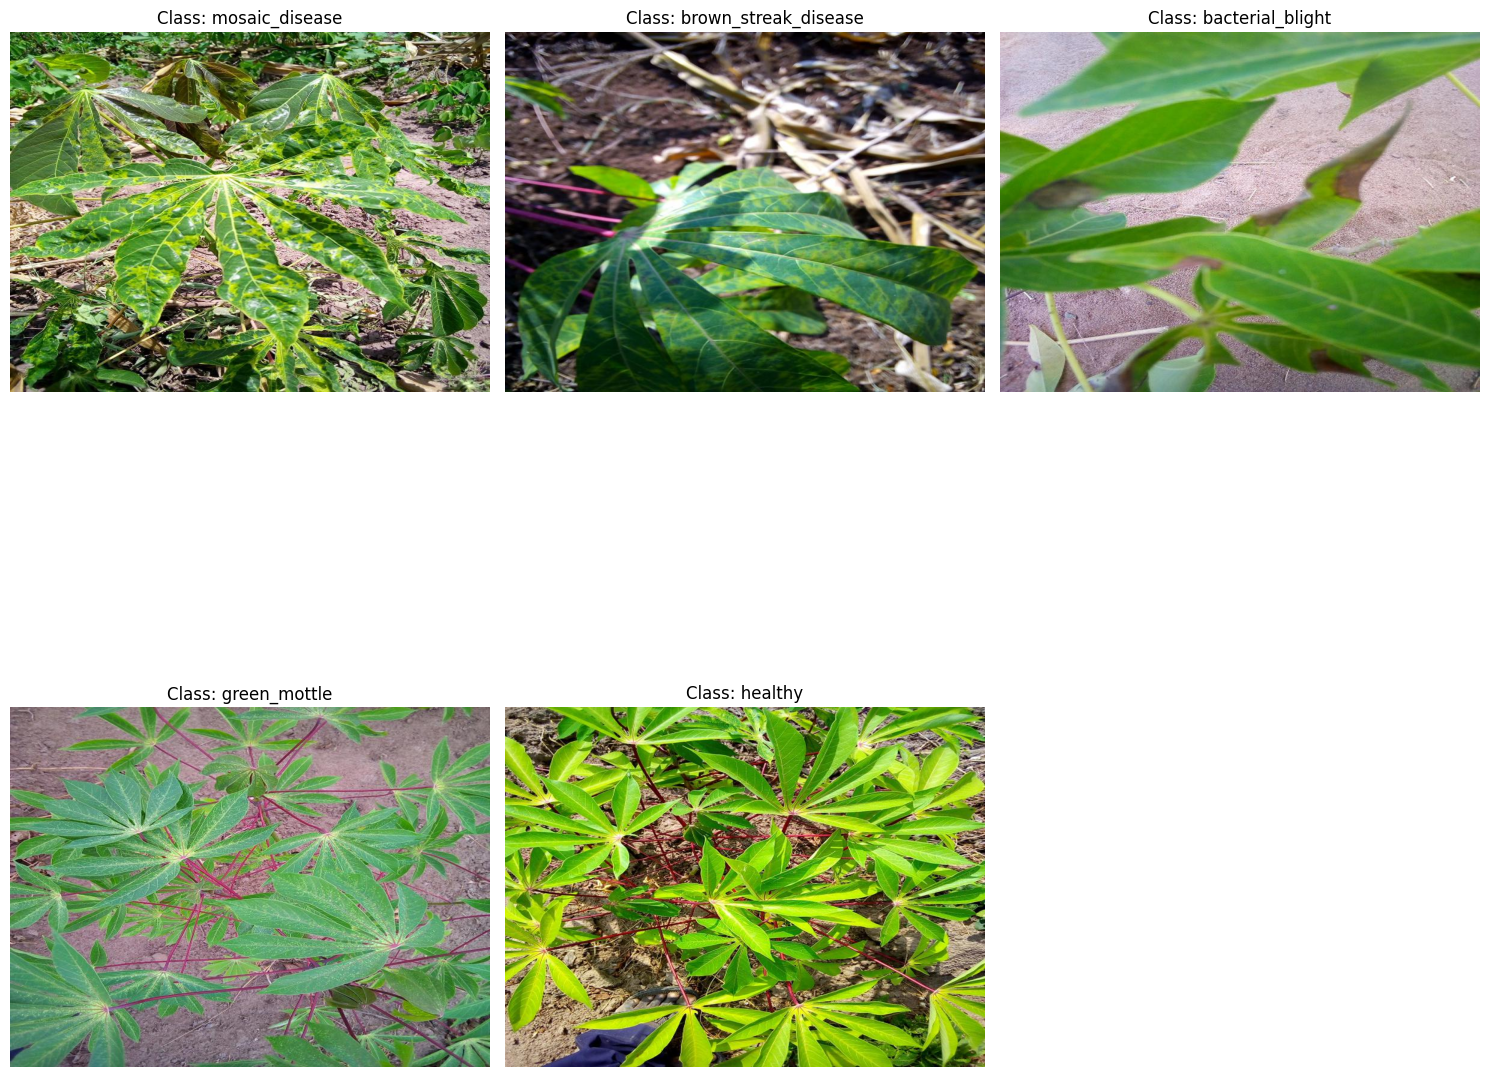

In [36]:
# Function to display images using subplots
def display_images_subplot(images, labels, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15), tight_layout=True)  # Add tight_layout=True
    axes = axes.flatten()

    for i in range(len(images)):
        full_path = os.path.join(dataset_path, images[i])
        image = cv2.imread(full_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV reads images in BGR format, convert to RGB
        axes[i].imshow(image)
        axes[i].set_title(f'Class: {labels[i]}')
        axes[i].axis('off')

    # Remove empty subplots
    for j in range(len(images), len(axes)):
        fig.delaxes(axes[j])

    plt.show()

# Select one image per class for display
unique_labels = df['label'].unique()
selected_images = []
selected_labels = []

for class_label in unique_labels:
    class_image = df[df['label'] == class_label].iloc[0]  # Select the first image for each class
    selected_images.append(class_image['image_path'])
    selected_labels.append(class_label)

# Calculate the number of rows and columns based on the number of unique labels
rows = 2  
cols = 3 

# Display images using subplots
display_images_subplot(selected_images, selected_labels, rows, cols)


### **Image size in train dataset**

In [37]:
from PIL import Image

# Load the first image in the train_df DataFrame
image_path = train_df['image_path'].iloc[0]
image = Image.open(image_path)

# Get the dimensions (size) of the image
image_size = image.size
print("Image size:", image_size)

Image size: (800, 600)


### **Image size in test dataset**

In [38]:
from PIL import Image

# Load the first image in the test_df DataFrame
image_path = test_df['image_path'].iloc[0]
image = Image.open(image_path)

# Get the dimensions (size) of the image
image_size = image.size
print("Image size:", image_size)

Image size: (800, 600)


### **Image size in validation dataset**

In [39]:
from PIL import Image

# Load the first image in the test_df DataFrame
image_path = val_df['image_path'].iloc[0]
image = Image.open(image_path)

# Get the dimensions (size) of the image
image_size = image.size
print("Image size:", image_size)

Image size: (800, 600)


### **Loading Pre-trained Pyramid Vision Transformer (PVT) Image Processor**

In [40]:
from transformers import AutoImageProcessor, AutoModelForImageClassification
import torch

# Load pre-trained Swin Transformer image processor and model
feature_extractor = AutoImageProcessor.from_pretrained("Zetatech/pvt-tiny-224")

preprocessor_config.json:   0%|          | 0.00/171 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/70.0k [00:00<?, ?B/s]

### **Dataset Preprocessing and DataLoader Setup for Cassava Leaf Disease Classification**

In [41]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder

# Define the image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=45),  # Add rotation with a random angle up to 45 degrees
    transforms.RandomHorizontalFlip(),      # Add random horizontal flip
    transforms.RandomVerticalFlip(),        # Add random vertical flip
    transforms.ToTensor(),
])

# Create a label encoder and fit it on your labels
label_encoder = LabelEncoder()
label_encoder.fit(train_df['label'])

# Convert labels to numerical representation
train_df['encoded_label'] = label_encoder.transform(train_df['label'])
val_df['encoded_label'] = label_encoder.transform(val_df['label'])
test_df['encoded_label'] = label_encoder.transform(test_df['label'])

class CassavaDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths.iloc[idx]  # Access image path using iloc
        label = self.labels.iloc[idx]  # Access label using iloc

        # Load and preprocess image
        image = Image.open(img_path).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)  # Apply the composed transformation

        return image, label



In [86]:
# Create a label encoder and fit it on your labels
label_encoder_check = LabelEncoder()
label_encoder_check.fit(train_df['label'])

# Transform class labels to numerical representations
train_df['encoded_label'] = label_encoder_check.transform(train_df['label'])

# Print unique numerical representations and their corresponding class labels
unique_encoded_labels = train_df[['label', 'encoded_label']].drop_duplicates()
print("Class Labels and their Encoded Representations:")
print(unique_encoded_labels)


Class Labels and their Encoded Representations:
                    label  encoded_label
227               healthy              3
800        mosaic_disease              4
671          green_mottle              2
968      bacterial_blight              0
743  brown_streak_disease              1


### **Processing Dataset Samples with Pyramid Vision Transformer (PVT) Feature Extractor**

In [42]:
def process_example(example):
    # Assuming the dataset returns a tuple with image_path and labels
    image_path, labels = example[0], example[1]

    # Use your feature_extractor to process the image_path
    inputs = feature_extractor(image_path, return_tensors='pt')
    inputs['labels'] = labels

    return inputs

In [43]:
    # Training dataset and loader
train_dataset_encoded = CassavaDataset(train_df['image_path'], train_df['encoded_label'], transform=transform)
train_loader = DataLoader(train_dataset_encoded, batch_size=10, shuffle=True, collate_fn=process_example)

# Validation dataset and loader
val_dataset_encoded = CassavaDataset(val_df['image_path'], val_df['encoded_label'], transform=transform)
val_loader = DataLoader(val_dataset_encoded, batch_size=10, shuffle=True, collate_fn=process_example)

# Test dataset and loader
test_dataset_encoded = CassavaDataset(test_df['image_path'], test_df['encoded_label'], transform=transform)
test_loader = DataLoader(test_dataset_encoded, batch_size=10, shuffle=False, collate_fn=process_example)


In [44]:
# Get one sample from each dataset
sample_train = train_dataset_encoded[0]
sample_val = val_dataset_encoded[0]
sample_test = test_dataset_encoded[0]

# Process each sample using the process_example function
processed_train = process_example(sample_train)
processed_val = process_example(sample_val)
processed_test = process_example(sample_test)

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


In [45]:
# Display the processed samples
print("Processed Train Sample:")
print(processed_train)

Processed Train Sample:
{'pixel_values': tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044,

In [46]:
print("\nProcessed Validation Sample:")
print(processed_val)


Processed Validation Sample:
{'pixel_values': tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1

In [47]:
print("\nProcessed Test Sample:")
print(processed_test)


Processed Test Sample:
{'pixel_values': tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044,

### **Printing Sizes of the First 10 Images from the Train Dataset with Labels**

In [48]:
# Print sizes of the first 10 images from the train dataset with labels
print("Train dataset - Image sizes:")
for i in range(10):
    img_path = train_df['image_path'].iloc[i]
    label = train_df['label'].iloc[i]
 
    # Load and preprocess image
    image = Image.open(img_path).convert('RGB')
    if transform is not None:
        image = transform(image)  # Apply the composed transformation

    print(f"Sample {i + 1} - Label: {label}, Image Size: {image.size()}")


Train dataset - Image sizes:
Sample 1 - Label: healthy, Image Size: torch.Size([3, 224, 224])
Sample 2 - Label: healthy, Image Size: torch.Size([3, 224, 224])
Sample 3 - Label: mosaic_disease, Image Size: torch.Size([3, 224, 224])
Sample 4 - Label: green_mottle, Image Size: torch.Size([3, 224, 224])
Sample 5 - Label: healthy, Image Size: torch.Size([3, 224, 224])
Sample 6 - Label: bacterial_blight, Image Size: torch.Size([3, 224, 224])
Sample 7 - Label: healthy, Image Size: torch.Size([3, 224, 224])
Sample 8 - Label: healthy, Image Size: torch.Size([3, 224, 224])
Sample 9 - Label: bacterial_blight, Image Size: torch.Size([3, 224, 224])
Sample 10 - Label: bacterial_blight, Image Size: torch.Size([3, 224, 224])


### **Printing Sizes of the First 10 Images from the Test Dataset with Labels**

In [49]:
# Print sizes of the first 10 images from the test dataset with labels
print("Test dataset - Image sizes:")
for i in range(10):
    img_path = test_df['image_path'].iloc[i]
    label = test_df['label'].iloc[i]

    # Load and preprocess image
    image = Image.open(img_path).convert('RGB')
    if transform is not None:
        image = transform(image)  # Apply the composed transformation

    print(f"Sample {i + 1} - Label: {label}, Image Size: {image.size()}")


Test dataset - Image sizes:
Sample 1 - Label: bacterial_blight, Image Size: torch.Size([3, 224, 224])
Sample 2 - Label: green_mottle, Image Size: torch.Size([3, 224, 224])
Sample 3 - Label: bacterial_blight, Image Size: torch.Size([3, 224, 224])
Sample 4 - Label: brown_streak_disease, Image Size: torch.Size([3, 224, 224])
Sample 5 - Label: mosaic_disease, Image Size: torch.Size([3, 224, 224])
Sample 6 - Label: brown_streak_disease, Image Size: torch.Size([3, 224, 224])
Sample 7 - Label: healthy, Image Size: torch.Size([3, 224, 224])
Sample 8 - Label: bacterial_blight, Image Size: torch.Size([3, 224, 224])
Sample 9 - Label: brown_streak_disease, Image Size: torch.Size([3, 224, 224])
Sample 10 - Label: green_mottle, Image Size: torch.Size([3, 224, 224])


### **Printing Sizes of the First 10 Images from the Validation Dataset with Labels**

In [50]:
# Print sizes of the first 10 images from the val dataset with labels
print("Validation dataset - Image sizes:")
for i in range(10):
    img_path = val_df['image_path'].iloc[i]
    label = val_df['label'].iloc[i]

    # Load and preprocess image
    image = Image.open(img_path).convert('RGB')
    if transform is not None:
        image = transform(image)  # Apply the composed transformation

    print(f"Sample {i + 1} - Label: {label}, Image Size: {image.size()}")


Validation dataset - Image sizes:
Sample 1 - Label: green_mottle, Image Size: torch.Size([3, 224, 224])
Sample 2 - Label: mosaic_disease, Image Size: torch.Size([3, 224, 224])
Sample 3 - Label: bacterial_blight, Image Size: torch.Size([3, 224, 224])
Sample 4 - Label: brown_streak_disease, Image Size: torch.Size([3, 224, 224])
Sample 5 - Label: green_mottle, Image Size: torch.Size([3, 224, 224])
Sample 6 - Label: healthy, Image Size: torch.Size([3, 224, 224])
Sample 7 - Label: brown_streak_disease, Image Size: torch.Size([3, 224, 224])
Sample 8 - Label: mosaic_disease, Image Size: torch.Size([3, 224, 224])
Sample 9 - Label: bacterial_blight, Image Size: torch.Size([3, 224, 224])
Sample 10 - Label: healthy, Image Size: torch.Size([3, 224, 224])


### **Custom Collate Function for PyTorch Dataloader in Image Classification**

In [51]:
def collate_fn(batch):
    images, labels = zip(*batch)

    return {
        'pixel_values': torch.stack(images),
        'labels': torch.tensor(labels)
    }

### **Metrics Computation Function for Image Classification Model Evaluation**

In [52]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(p):
    predictions = np.argmax(p.predictions, axis=1)
    references = p.label_ids

    accuracy = accuracy_score(references, predictions)
    precision = precision_score(references, predictions, average='weighted')
    recall = recall_score(references, predictions, average='weighted')
    f1 = f1_score(references, predictions, average='weighted')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }


In [53]:
model_name_or_path = "Zetatech/pvt-tiny-224"

### **Initializing Pyramid Vision Transformer (PVT) Model for Image Classification with Custom Labels Mapping**

In [54]:
# Initialize the EfficientFormer model for image classification
model = AutoModelForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(label_encoder.classes_),
    ignore_mismatched_sizes=True,
    id2label={str(i): c for i, c in enumerate(label_encoder.classes_)},
    label2id={c: str(i) for i, c in enumerate(label_encoder.classes_)}
)

model.safetensors:   0%|          | 0.00/52.9M [00:00<?, ?B/s]

Some weights of PvtForImageClassification were not initialized from the model checkpoint at Zetatech/pvt-tiny-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 512]) in the checkpoint and torch.Size([5, 512]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [55]:
model

PvtForImageClassification(
  (pvt): PvtModel(
    (encoder): PvtEncoder(
      (patch_embeddings): ModuleList(
        (0): PvtPatchEmbeddings(
          (projection): Conv2d(3, 64, kernel_size=(4, 4), stride=(4, 4))
          (layer_norm): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (1): PvtPatchEmbeddings(
          (projection): Conv2d(64, 128, kernel_size=(2, 2), stride=(2, 2))
          (layer_norm): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (2): PvtPatchEmbeddings(
          (projection): Conv2d(128, 320, kernel_size=(2, 2), stride=(2, 2))
          (layer_norm): LayerNorm((320,), eps=1e-06, elementwise_affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (3): PvtPatchEmbeddings(
          (projection): Conv2d(320, 512, kernel_size=(2, 2), stride=(2, 2))
          (layer_norm): LayerNorm((512,),

### **Configuring Training Arguments for Pyramid Vision Transformer (PVT) Model Training on Cassava Leaf Disease Dataset**

In [56]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./PVT-base-Cassava-demo-v5",
  per_device_train_batch_size=10,
  evaluation_strategy="steps",
  num_train_epochs=5,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

### **Initializing Trainer for Pyramid Vision Transformer (PVT) Model Training on Cassava Leaf Disease Dataset**

In [57]:
from transformers import Trainer
# Create a Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=train_loader.dataset,
    eval_dataset=val_loader.dataset,
    tokenizer=feature_extractor,
)


### **Training Pyramid Vision Transformer (PVT) Model on Cassava Leaf Disease Dataset**

In [58]:
train_results = trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
100,1.408700,1.188274,0.530000,0.619766,0.530000,0.494069
200,1.089000,1.038753,0.568000,0.580869,0.568000,0.546386
300,1.098600,1.028700,0.578000,0.691288,0.578000,0.564141
400,0.933800,0.833339,0.670000,0.702275,0.670000,0.669361
500,0.903600,0.902182,0.646000,0.719976,0.646000,0.632987
600,0.855700,0.875932,0.664000,0.696035,0.664000,0.666796
700,1.035000,0.804338,0.676000,0.686282,0.676000,0.678509
800,0.867700,0.793527,0.686000,0.703269,0.686000,0.680672
900,0.838500,0.758814,0.718000,0.735151,0.718000,0.715105
1000,0.797700,0.888363,0.686000,0.705573,0.686000,0.680651


### **Saving Pyramid Vision Transformer (PVT) Model and Training Metrics After Training on Cassava Leaf Disease Dataset**

In [59]:
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =         5.0
  total_flos               = 213966910GF
  train_loss               =      0.7954
  train_runtime            =  0:07:12.36
  train_samples_per_second =      46.257
  train_steps_per_second   =       4.626


### **Evaluating Pyramid Vision Transformer (PVT) Model on Validation Set and Logging Metrics**

In [60]:
metrics = trainer.evaluate(val_loader.dataset)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        5.0
  eval_accuracy           =      0.728
  eval_f1                 =     0.7293
  eval_loss               =     0.6652
  eval_precision          =     0.7387
  eval_recall             =      0.728
  eval_runtime            = 0:00:05.01
  eval_samples_per_second =     99.781
  eval_steps_per_second   =     12.572


### **Evaluating Pyramid Vision Transformer (PVT) Model on Test Set and Logging Evaluation Metrics**

In [61]:
metrics = trainer.evaluate(test_loader.dataset)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        5.0
  eval_accuracy           =       0.76
  eval_f1                 =       0.76
  eval_loss               =     0.6758
  eval_precision          =     0.7613
  eval_recall             =       0.76
  eval_runtime            = 0:00:08.72
  eval_samples_per_second =      57.32
  eval_steps_per_second   =      7.222


In [62]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate on the test dataset
test_results = trainer.predict(test_loader.dataset)

# Compute metrics
metrics = compute_metrics(test_results)

# Print the computed metrics
print(f"Accuracy: {metrics['accuracy']:.4f}")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall: {metrics['recall']:.4f}")
print(f"F1 Score: {metrics['f1']:.4f}")


Accuracy: 0.7660
Precision: 0.7649
Recall: 0.7660
F1 Score: 0.7637


### **Confusion Matrix for Cassava Leaf Disease Classification**

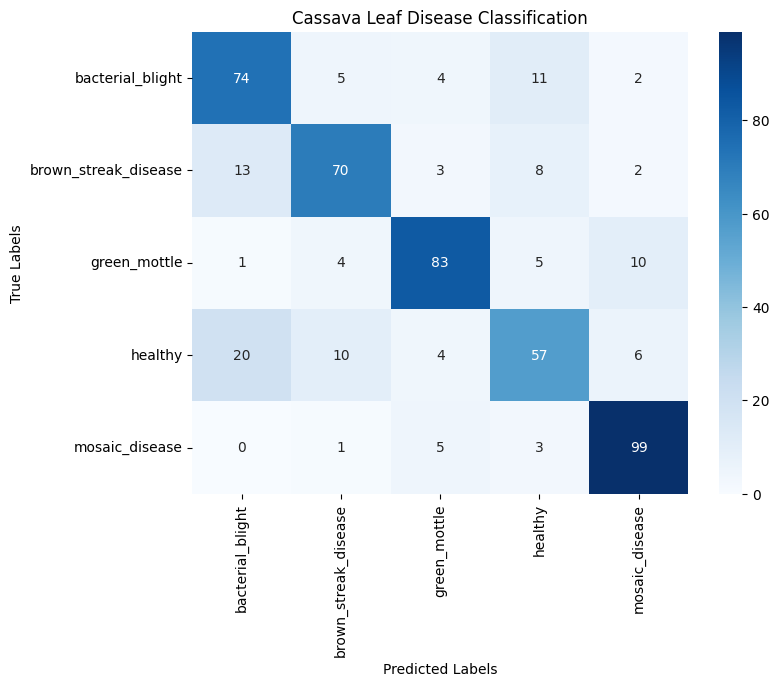

In [63]:
# Compute and display the confusion matrix
conf_matrix = confusion_matrix(test_results.label_ids, np.argmax(test_results.predictions, axis=1))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Cassava Leaf Disease Classification')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### **Load Image Processor and Model for Cassava Leaf Disease Classification**


In [79]:
from transformers import AutoImageProcessor, AutoModelForImageClassification

# Define paths to your checkpoint
checkpoint_path = "/kaggle/working/PVT-base-Cassava-demo-v5/checkpoint-2000"

# Load the image processor
image_processor = AutoImageProcessor.from_pretrained(checkpoint_path)

# Load the model with ignore_mismatched_sizes=True
model = AutoModelForImageClassification.from_pretrained(checkpoint_path, ignore_mismatched_sizes=True, num_labels=5)

### **Predict Cassava Leaf Disease Labels for Given Image Paths**

In [93]:
# List of image paths
image_paths = [
    "/kaggle/input/cassava-leaf-disease-classification/data/Cassava___mosaic_disease/1000201771.jpg",
    "/kaggle/input/cassava-leaf-disease-classification/data/Cassava___bacterial_blight/1001320321.jpg",
    "/kaggle/input/cassava-leaf-disease-classification/data/Cassava___green_mottle/1017670009.jpg"
]

# Loop through the list of image paths and make predictions
for image_path in image_paths:
    # Load the image using PIL
    image = Image.open(image_path)

    # Preprocess the image using the image processor
    inputs = image_processor(images=image, return_tensors="pt")

    with torch.no_grad():
        logits = model(**inputs).logits

    # Map model output indices to your original class labels
    predicted_label = logits.argmax(-1).item()
    original_class_label = label_encoder.inverse_transform([predicted_label])[0]

    # Print the predicted label for each image
    print(f"Image: {image_path}, Predicted Label: {original_class_label}")


Image: /kaggle/input/cassava-leaf-disease-classification/data/Cassava___mosaic_disease/1000201771.jpg, Predicted Label: mosaic_disease
Image: /kaggle/input/cassava-leaf-disease-classification/data/Cassava___bacterial_blight/1001320321.jpg, Predicted Label: healthy
Image: /kaggle/input/cassava-leaf-disease-classification/data/Cassava___green_mottle/1017670009.jpg, Predicted Label: green_mottle


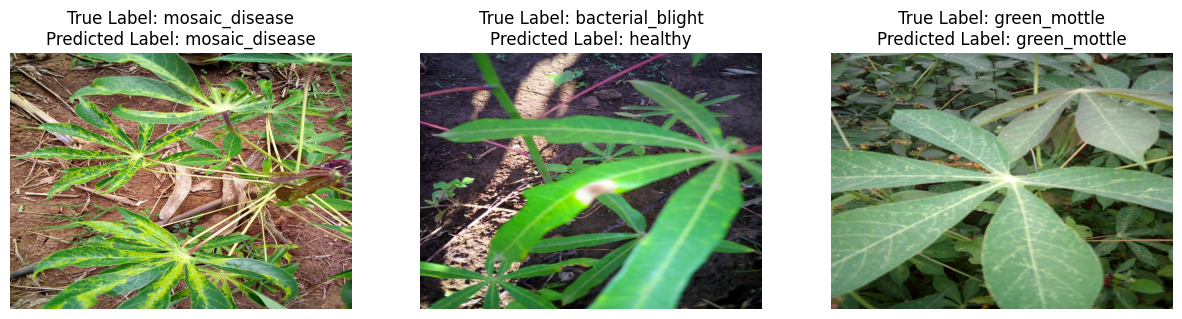

In [99]:
import matplotlib.pyplot as plt

# List of image paths and their true labels
image_paths_and_labels = [
    ("/kaggle/input/cassava-leaf-disease-classification/data/Cassava___mosaic_disease/1000201771.jpg", "mosaic_disease"),
    ("/kaggle/input/cassava-leaf-disease-classification/data/Cassava___bacterial_blight/1001320321.jpg", "bacterial_blight"),
    ("/kaggle/input/cassava-leaf-disease-classification/data/Cassava___green_mottle/1017670009.jpg", "green_mottle")
]

# Set up subplot parameters
num_rows = 1
num_cols = len(image_paths_and_labels)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5))

# Loop through the list of image paths and true labels, and make predictions
for i, (image_path, true_label) in enumerate(image_paths_and_labels):
    # Load the image using PIL
    image = Image.open(image_path)

    # Preprocess the image using the image processor
    inputs = image_processor(images=image, return_tensors="pt")

    with torch.no_grad():
        logits = model(**inputs).logits

    # Map model output indices to your original class labels
    predicted_label = logits.argmax(-1).item()
    original_class_label = label_encoder.inverse_transform([predicted_label])[0]

    # Display the image along with true and predicted labels in the subplot
    axes[i].imshow(image)
    axes[i].set_title(f"True Label: {true_label}\nPredicted Label: {original_class_label}")
    axes[i].axis("off")

plt.show()
